# Transfer Learning

With certain data types it is possible to use the weights learned in one task to be **transferred** to another task. For example in a task that is used to detect Animals and Vehicles in images (as done in CIFAR10) could be reused to classify dogs and cats. 

Transfer Learning is heavily used in Image recognition and Natural Language Processing (NLP) related tasks.

In [1]:
!pip install tqdm
!conda install -y Pillow

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /root/miniconda3:

The following packages will be UPDATED:

    conda: 4.3.22-py36_0 --> 4.3.23-py36_0

conda-4.3.23-p 100% |################################| Time: 0:00:00  20.76 MB/s


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from urllib.request import urlretrieve
from os.path import isfile, isdir, getsize
from os import mkdir, makedirs, remove
from tqdm import tqdm

import zipfile
import pickle

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from keras.preprocessing.image import ImageDataGenerator

import glob
import shutil

%matplotlib inline

Using Theano backend.


Download and extract the doge and cate pictures.

In [3]:
catdog_dataset_folder_path = 'catdog'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('catdog.zip'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Doge n Cate Dataset') as pbar:
        urlretrieve(
            'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip',
            'catdog.zip',
            pbar.hook)

if not isdir(catdog_dataset_folder_path):
    mkdir(catdog_dataset_folder_path)
    with zipfile.ZipFile('catdog.zip') as f:
        f.extractall('./'+catdog_dataset_folder_path)
        
        

Unfortunately some of the files are corrupt so we need to clean these out:

In [4]:
!apt-get install -y jhead > /dev/null 2>&1
!jhead -de catdog/PetImages/Cat/*.jpg > /dev/null 2>&1 
!jhead -de catdog/PetImages/Dog/*.jpg > /dev/null 2>&1

files = glob.glob(catdog_dataset_folder_path+'/PetImages/**/*.jpg')
labels = np.array([0]*12500+[1]*12500)

size = np.zeros(len(files))
for i,f in enumerate(files):
    size[i] = getsize(f)
    
idx = np.where(size==0)[0]
for i in idx[::-1]:
    del files[i]
    labels = np.delete(labels, i)

Randomly choose 20000 images and moves them to training and the rest to testing folders

In [5]:
len_data = len(files)
train_examples = 20000
test_examples = len_data - train_examples

# randomly choose 20000 as training and testing cases
permutation = np.random.permutation(len_data)
train_set = [files[i] for i in permutation[:]]
test_set = [files[i] for i in permutation[-test_examples:]]
train_labels = labels[permutation[:train_examples]]
test_labels = labels[permutation[-test_examples:]]

train_folder = catdog_dataset_folder_path+'/train'
test_folder = catdog_dataset_folder_path+'/test'

if isdir(train_folder): #if directory already exists
    shutil.rmtree(train_folder)    
if isdir(test_folder): #if directory already exists
    shutil.rmtree(test_folder)    
makedirs(train_folder+'/cat/')
makedirs(train_folder+'/dog/')
makedirs(test_folder+'/cat/')
makedirs(test_folder+'/dog/')

for f,i in zip(train_set, train_labels):
    if i==0:
        shutil.copy2(f, train_folder+'/cat/')
    else:
        shutil.copy2(f, train_folder+'/dog/')
        
for f,i in zip(test_set, test_labels):
    if i==0:
        shutil.copy2(f, test_folder+'/cat/')
    else:
        shutil.copy2(f, test_folder+'/dog/')  

View some sample images:

Found 20000 images belonging to 2 classes.


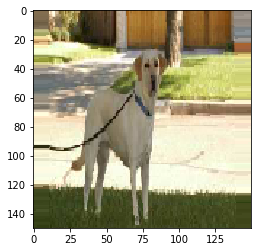

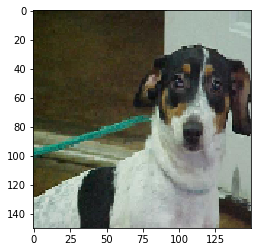

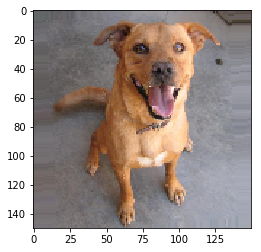

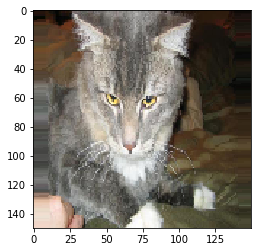

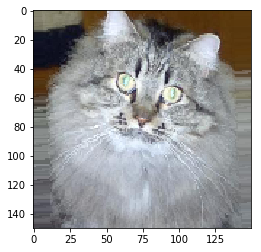

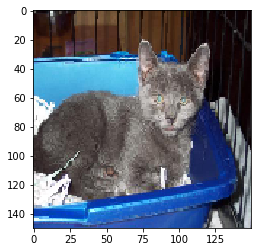

In [6]:
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=5,
        zoom_range=0.2,
        horizontal_flip=True)

img_height = img_width = 150
channels = 3
train_generator = datagen.flow_from_directory(
    train_folder,
    color_mode = "rgb",
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode=None)

i = 0
img_list = []
for batch in train_generator: #.flow(x, batch_size=1)
    img_list.append(batch)
    i += 1
    if i > 5:
        break
        

for img in img_list:
    plt.imshow(np.squeeze(img))
    plt.show()        

## Basic logistic multiclass classification:

In [7]:
batch_size = 1000
train_generator = datagen.flow_from_directory(
    train_folder,
    color_mode = "rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 20000 images belonging to 2 classes.


In [8]:
x_train, y_train = next(train_generator)
x_test, y_test = next(train_generator)

In [9]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
logistic.fit(x_train.reshape(batch_size,-1), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [10]:
y_pred = logistic.predict(x_test.reshape(len(x_test), -1))
y_pred[:10]

array([ 1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.], dtype=float32)

Predicting the probabilities for the first 3 images:

In [11]:
logistic.predict_proba(x_test[:3].reshape(3,-1))

array([[ 0.45270886,  0.54729114],
       [ 0.44448103,  0.55551897],
       [ 0.00495017,  0.99504983]])

Accuracy of the predictions:

In [12]:
np.count_nonzero(y_pred == y_test)/len(y_test)

0.514

## Convolution Neural Networks (CNN)

In [13]:
Conv2D?

In [14]:
MaxPool2D?

In [15]:
model = Sequential()

model.add(Conv2D(8, kernel_size=(3,3), padding='same', input_shape = (img_width,img_height,channels)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(3, 3)))

model.add(Conv2D(16, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 8)       224       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 50, 50, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 16)        0         
__________

In [17]:
batch_size = 128
train_generator = datagen.flow_from_directory(
    train_folder,
    color_mode = "rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')
model.fit_generator(train_generator, train_examples//batch_size, epochs=2)

Found 20000 images belonging to 2 classes.
Epoch 1/2
156/156 [==============================] - 561s - loss: 0.6205 - acc: 0.6613   
Epoch 2/2
156/156 [==============================] - 566s - loss: 0.5423 - acc: 0.7269   


In [18]:
batch_size = 1
test_generator = datagen.flow_from_directory(
    test_folder,
    color_mode = "rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary', 
    shuffle=False)
y_pred = model.predict_generator(test_generator, test_examples//batch_size, workers=4)
# model.predict_classes(test_x)
# np.count_nonzero(y_pred == test_y)/len(test_y)

Found 4998 images belonging to 2 classes.


In [19]:
correct = 0
for i, f in enumerate(test_generator.filenames):
    if f.startswith('cat') and y_pred[i]<0.5:
        correct +=1
    if f.startswith('dog') and y_pred[i]>=0.5:
        correct +=1

print('Correct predictions: '+str(correct/len(test_generator.filenames)))        

Correct predictions: 0.5058023209283713


In [20]:
batch_size = 6
test_generator = datagen.flow_from_directory(
    test_folder,
    color_mode = "rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary', 
    shuffle=True)
x_test, y_test = next(test_generator)

p = model.predict(x_test)
p = np.hstack([y_pred, 1-y_pred])
label_dict = {0: 'cat', 1: 'dog'}

Found 4998 images belonging to 2 classes.


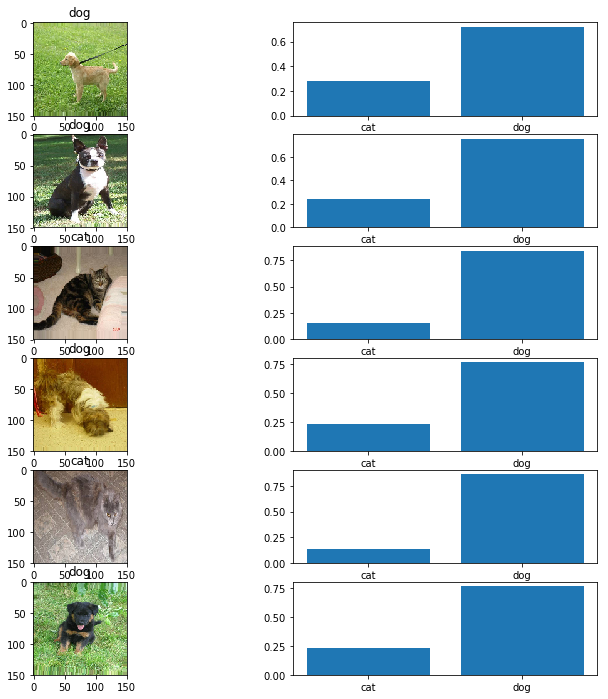

In [21]:
plt.figure(figsize=(12,12))

for i in range(batch_size):
    plt.subplot(batch_size,2,2*i+1)
    plt.imshow(x_test[i])
    plt.title(label_dict[y_test[i]])
    
    plt.subplot(batch_size,2,2*i+2)
    plt.bar(range(2),p[i])
    plt.xticks(range(2), ['cat', 'dog'])
#     plt.show()

plt.show()

In [22]:
p

array([[ 0.28162625,  0.71837378],
       [ 0.24552229,  0.75447774],
       [ 0.15673721,  0.84326279],
       ..., 
       [ 0.36343947,  0.63656056],
       [ 0.29009002,  0.70990998],
       [ 0.27991441,  0.72008562]], dtype=float32)

## Transfer Learning

In [23]:
from keras import applications

datagen = ImageDataGenerator(rescale=1.0/255)
model = applications.VGG16(include_top=)

In [26]:
applications.VGG16?